# Lab 2.1 - Metric Learning

Celem zadania jest obserwacja jak zmiana wykorzystywanej przez klasyfikator k-NN metryki wpływa na kształt granicy decyzyjnej, a więc w efekcie na jego skuteczność.

**Wykonanie rozwiązań: Marcin Przewięźlikowski**

https://github.com/mprzewie/ml_basics_course

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from typing import Dict, Tuple
import cv2
from dataset_ops import (
    load_dataset, visualize_dataset, slice_dataset, sliced_dataset_name
)
from copy import deepcopy

## Przygotowanie datasetów

Korzystając np. z omawianej na zajęciach metody "z paintem" (lub innej), przygotuj 3 różne (ciekawe) dwuwymiarowe zbiory danych. Przynajmniej raz powinna wystąpić każda z poniższych sytuacji:
- 3 lub więcej różnych klas
- klasy dobrze odseparowane w danym regionie;
- klasy częściowo przemieszane, nachodzące na siebie;
- wyspa jednej klasy wewnątrz regionu drugiej;
- różne gęstości punktów wewnątrz poszczególnych klas;
- nieregularne kształty obszaru jednej z klas;
- niesymetryczny kształt całego zbioru (np. podłużne wrzeciono).

Jeżeli korzystasz z metody "z paintem" to pamiętaj, by przed zapisaniem zbioru nałożyć na punkty niewielki szum. Przygotowane zbiory możesz wykorzystać w obu zadaniach domowych.


In [3]:
orig_datasets = {}
n_datasets = 3
x1_size, x2_size = (100, 100)
for i in range(3):
    X, y = load_dataset(f"ds_{i + 1}.png", space_size=(x1_size, x2_size), dropout=0.8)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    orig_datasets[f"{i}_train"] = X_train, y_train
    orig_datasets[f"{i}_test"] = X_test, y_test

0_train


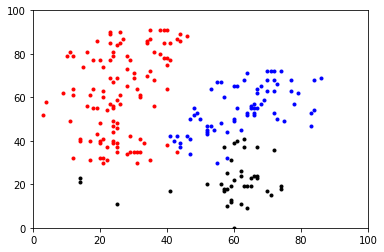

0_test


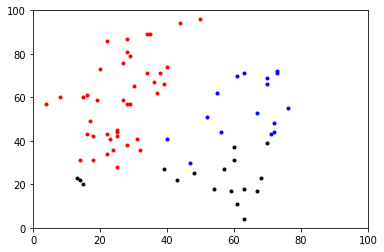

1_train


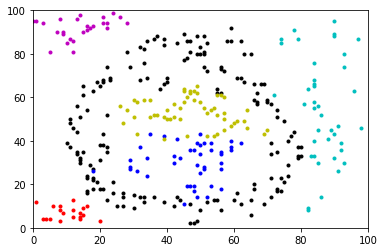

1_test


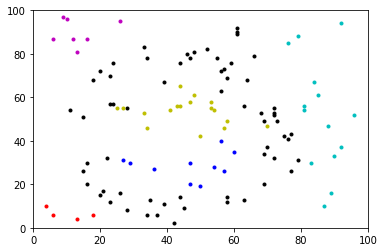

2_train


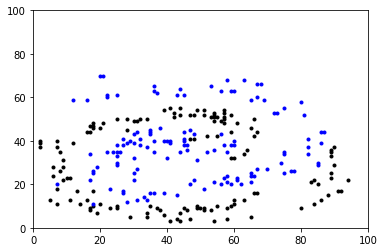

2_test


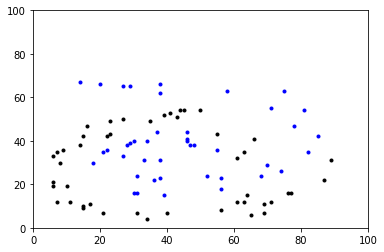

In [4]:
for name, (X, y) in orig_datasets.items():
    print(name)
    visualize_dataset(X, y)
    plt.show()

Zadanie rozpoczynamy od przygotowania testowych zbiorów danych. Następnie dla obu z tych zbiorów trenujemy poniższe 4 warianty klasyfikatora k-NN:

Pierwsze kilka KNN będzie działać na niepodzielonych datasetach ($n\_datasets = 1$). Ostatni będzie działał na podzielonych ($n\_datasets = 5$).

In [5]:
all_coords = np.arange(0, 100)
X_all = np.array([[[x0, x1] for x1 in all_coords] for x0 in all_coords]).reshape(-1, 2)
y_all_ph = np.array([0 for _ in X_all])
all_sliced = {}
datasets = {}
for n_slices in [1, 5]:
    for ds_name, (X, y) in orig_datasets.items():
        sliced = slice_dataset(X, y, n_slices=n_slices)
        for (x0, x1), (X_s, y_s) in sliced.items():
            datasets[sliced_dataset_name(ds_name, n_slices, x0, x1)] = X_s, y_s
    sliced_all_by_x0_x1 = slice_dataset(X_all, y_all_ph, n_slices=n_slices)
    for (x0, x1), (X_s, y_s) in sliced_all_by_x0_x1.items():
        all_sliced[(n_slices, x0, x1)] = X_s, y_s

In [6]:
def train_knns(
    knn_prototype: KNeighborsClassifier, 
    n_slices: int
) -> Dict[Tuple[int, int, int], KNeighborsClassifier]:
    knn_dict = {}
    for i in range(n_datasets):
        for x0 in range(n_slices):
            for x1 in range(n_slices): 
                ds_name = sliced_dataset_name(f"{i}_train", n_slices, x0, x1)
                X_train, y_train = datasets[ds_name]
                if X_train.shape[0] > 0:
                    knn = deepcopy(knn_prototype)
                    knn.fit(X_train, y_train)
                    knn_dict[(i, x0, x1)] = knn
                else:
                    knn_dict[(i, x0, x1)] = None
        plt.show()
    return knn_dict

In [7]:
knns = {}

### k-NN z k=1, głosowaniem większościowym i metryką Euklidesa

In [8]:
KNN1_NAME = "k1_uniform_eucli"
KNN1_PROTOTYPE = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
knns[KNN1_NAME] = train_knns(KNN1_PROTOTYPE, n_slices=1)

 ### k-NN z k=3, głosowaniem większościowym i metryką Euklidesa

In [9]:
KNN2_NAME = "k3_uniform_eucli"
KNN2_PROTOTYPE = KNeighborsClassifier(n_neighbors=3, algorithm="brute")
knns[KNN2_NAME] = train_knns(KNN2_PROTOTYPE, n_slices=1)

### k-NN z k=3, głosowaniem ważonym odległością i metryką Euklidesa

In [10]:
KNN3_NAME = "k3_weighted_eucli"
KNN3_PROTOTYPE = KNeighborsClassifier(n_neighbors=3, weights="distance", algorithm="brute")
knns[KNN3_NAME] = train_knns(KNN3_PROTOTYPE, n_slices=1)

### k-NN z k=1, głosowaniem większościowym i metryką Mahalanobisa

In [11]:
KNN4_NAME = "k1_weighted_mahalan"
KNN4_PROTOTYPE = KNeighborsClassifier(
    n_neighbors=1, 
    weights="distance", 
    algorithm="brute", 
    metric="mahalanobis"
)
knns[KNN4_NAME] = train_knns(KNN4_PROTOTYPE, n_slices=1)

### k-NN z k=1, głosowaniem większośćiowym i metryką Mahalanobisa zależną od regionu
Aby zrealizować ostatni punkt wykonaj następujące kroki:
 * podziel obszar w którym leży zbiór na kilka podobszarów (np. 5x5);
 * dla każdego z podobszarów wyznacz macierz kowariancji (używaną przez metrykę Mahalanobisa) tylko w oparciu o obserwacje leżące w tym podobszarze i podobszarach do niego przyległych;
 * w zależności od klasyfikowanego regionu korzystaj z macierzy jemu właściwej.
 

In [12]:
KNN5_NAME = "k1_weighted_mahalan_split"
KNN5_PROTOTYPE = KNeighborsClassifier(
                    n_neighbors=1, 
                    algorithm="brute", 
                    metric="mahalanobis"
                )

knns[KNN5_NAME] = train_knns(KNN5_PROTOTYPE, n_slices=5)

## Ewaluacja
Dla każdej pary zbiór-klasyfikator zwizualizuj wygląd granicy decyzyjnej oraz oszacuj % błąd takiego klasyfikatora (pamiętaj, że wymaga to podziału zbioru na treningowy i testowy). Skomentuj uzyskane wyniki - bądź krytyczny i nie zakładaj z góry oczekiwanych wniosków.

In [13]:
slices_dict = {
    KNN1_NAME: 1,
    KNN2_NAME: 1,
    KNN3_NAME: 1,
    KNN4_NAME: 1,
    KNN5_NAME: 5
}

dataset 0 n_classes = 3
k1_uniform_eucli
accuracy on 0 : 0.972972972972973


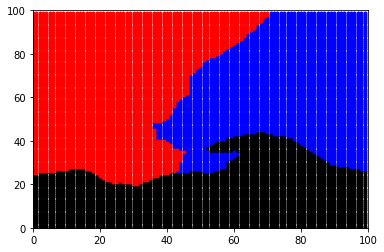

k3_uniform_eucli
accuracy on 0 : 0.9459459459459459


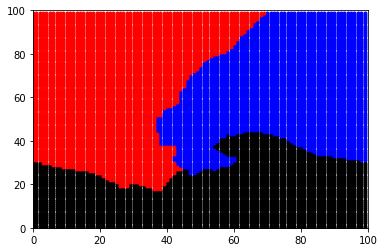

k3_weighted_eucli
accuracy on 0 : 0.9594594594594594


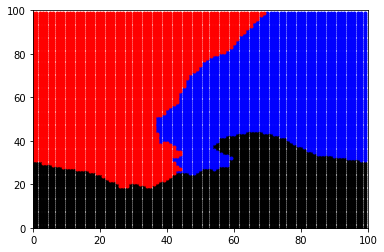

k1_weighted_mahalan
accuracy on 0 : 0.972972972972973


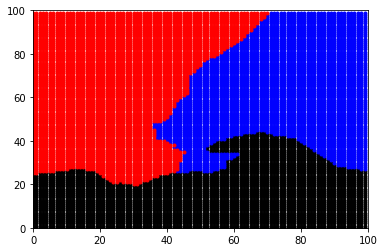

k1_weighted_mahalan_split
accuracy on 0 : 0.9854519774011299


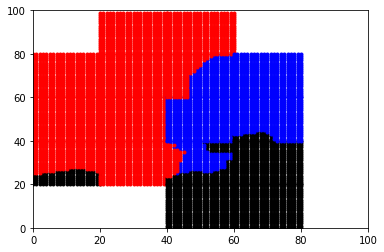


dataset 1 n_classes = 6
k1_uniform_eucli
accuracy on 1 : 0.9130434782608695


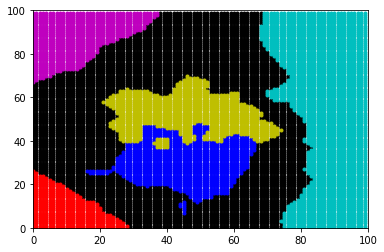

k3_uniform_eucli
accuracy on 1 : 0.9478260869565217


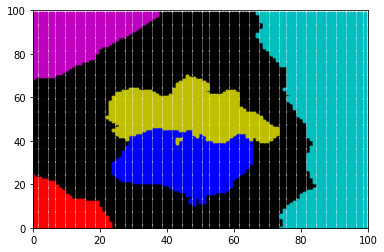

k3_weighted_eucli
accuracy on 1 : 0.9478260869565217


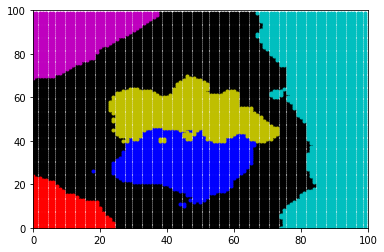

k1_weighted_mahalan
accuracy on 1 : 0.9217391304347826


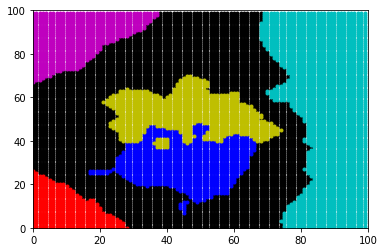

k1_weighted_mahalan_split
accuracy on 1 : 0.9709944446488354


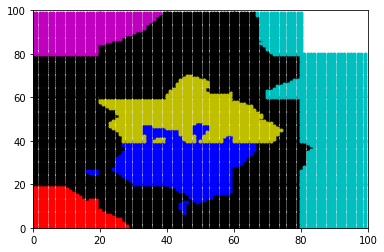


dataset 2 n_classes = 2
k1_uniform_eucli
accuracy on 2 : 0.9659090909090909


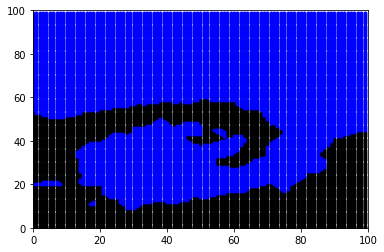

k3_uniform_eucli
accuracy on 2 : 0.9886363636363636


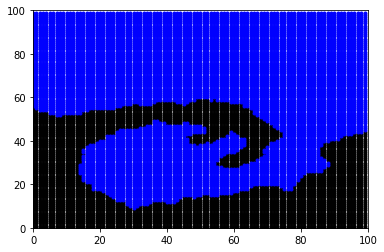

k3_weighted_eucli
accuracy on 2 : 0.9772727272727273


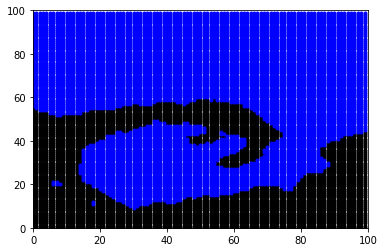

k1_weighted_mahalan
accuracy on 2 : 0.9204545454545455


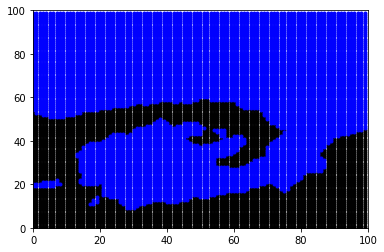

k1_weighted_mahalan_split
accuracy on 2 : 0.9674660626056697


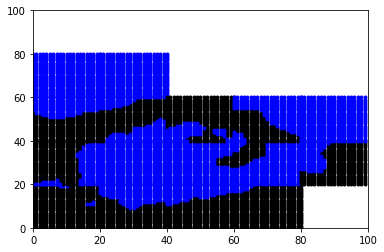

In [14]:
for i in range(n_datasets):
    _, y_train = orig_datasets[f"{i}_train"]
    n_classes = len(np.unique(y_train))
    print("dataset", i, "n_classes =", n_classes)
    for name, classifiers in knns.items():
        print(name)
        accuracies = []
        weights = []
        n_slices = slices_dict[name]
        for x0 in range(n_slices):
            for x1 in range(n_slices):
                knn = classifiers[(i, x0, x1)]
                ds_name = sliced_dataset_name(f"{i}_test", n_slices, x0, x1)
                X_test, y_test = datasets[ds_name]
                if knn is not None and X_test.shape[0] > 1:
                    weight = X_test.shape[0]
                    accuracy = knn.score(X_test, y_test)
                    X_all_s, _ = all_sliced[(n_slices, x0, x1)]
                    y_all = knn.predict(X_all_s)
                    visualize_dataset(X_all_s, y_all, n_classes)
                else: 
                    weight, accuracy = 0, 0
                accuracies.append(accuracy)
                weights.append(accuracy)
        accuracies = np.array(accuracies)
        weighs = np.array(weights)
        total_acc = np.average(accuracies, weights=weights)
        print("accuracy on", i, ":", total_acc)
        plt.show()
    print()
        

* Implementacje KNN ze Skikit-Learn są w stanie osiągnąć bardzo wysokie dokładności na zadanych datasetach - jest to możliwe, gdyż są one dość gęste

* KNN głosujący wśrod 3 najbliższych sąsiadów radzi sobie słabiej niż KNN szukający 1 najbliższego sąsiada - pojawia się to jednak dopiero przy obniżeniu gęstości datasetów

* KNN z głoosowaniem ważonym odległością i metryką Euklidesową radzi sobie lepiej niż pozostałe KNN z metryką Euklidesową - co ma sens, gdyż dzięki ważeniu odległości możemy priorytetyzować bliższych sąsiadów

* KNN z metryką Mahalanobisa radzi sobie co najmniej tak dobrze, jak KNN z metryką Euklidesową - nie dziwi to, gdyż metryka Euklidesowa jest szczególnym przypadkiem metryki Mahalanobisa. Widać też, że KNNy trenowane metryką Mahalanobisa są w stanie uchwycić znacznie bardziej szczegółowe granice klasyfikacji.

* KNN z metryką Mahalanonbisa działający na konkretnym obszarze prawie zawsze radzi sobie lepiej niż KNN nauczony na całej przestrzeni datasetu - to również nie dziwi, bo mamy tu do czynienia z większą ilością modeli wyuczonych na bardziej specyficznych datasetach. Warto jednak zauwazyć, że granice decyzyjne często pokrywają się z granicami obszarów, można więc przypuszczać że te specyfikacje datasetów powodują pewien overfitting.
